In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
from math import log
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import time
import scipy
from sklearn.externals import joblib # create pickles for models, avoid retrains
import operator
from sklearn import linear_model
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix # classification evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score # regression evaluation
import pylab 
import xgboost as xgb
from gensim.utils import tokenize
import gensim
import pyemd
# setup visual output configs
sns.set_style('darkgrid')
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 200
pd.set_option('display.width', 1000)
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
for root, dirs, files in os.walk("./data", topdown=False):
    zip_files = glob.glob(root + '/*.zip')
    print("Unzipping...")
    print(zip_files)
    for zip_filename in zip_files:
        dir_name = os.path.splitext(zip_filename)[0]
        zip_handler = zipfile.ZipFile(zip_filename, "r")
        zip_handler.extractall(root)

Unzipping...
['./data/sample_submission.csv.zip', './data/train.csv.zip', './data/test.csv.zip']


In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.set_index("id", drop=True, inplace=True)

In [2]:
train = pd.read_pickle('./data/train_processed.pkl')
test = pd.read_pickle('./data/test_processed.pkl')

FileNotFoundError: [Errno 2] No such file or directory: './data/train_processed.pkl'

In [3]:
print("{}% of the data is dedicated to train the final model".format((100*train.shape[0])/(train.shape[0] + test.shape[0])))
print(train.shape, test.shape)

14.700994805253362% of the data is dedicated to train the final model
(404290, 5) (2345796, 3)


In [4]:
test.sample(1)

,test_id,question1,question2
1628274,1628274,Which colleges can I get with rank of 1.18lac in JEE Main below 2016?,I got 44695 rank in JEE used Main 2016. Which college can I get with CS/IT?


In [5]:
train.sample(1)

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
120245,195053,195054,What does it feel like to get divorced?,What is it like being divorced?,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d44aebb10>]], dtype=object)

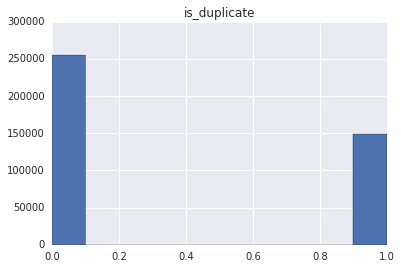

In [8]:
train.hist(column="is_duplicate")

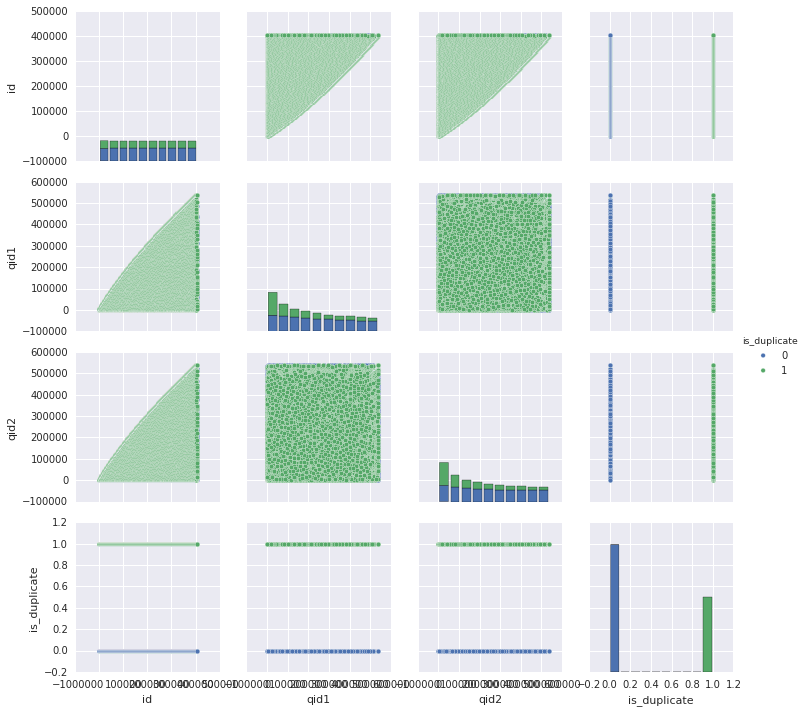

In [18]:
sns.pairplot(train, hue="is_duplicate")

In [6]:
#from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
import multiprocessing
import difflib
#train.question1 = train.question1.apply(lambda x: unidecode(str(x)))
#train.question2 = train.question2.apply(lambda x: unidecode(str(x)))
# word match
#z1 = tfidf.transform(df_q.question1)
#z2 = tfidf.transform(df_q.question2)
#df_q['q1_tfidf_sum'] = z1.sum(axis = 1)
#df_q['q2_tfidf_sum'] = z2.sum(axis = 1)
#df_q['q1_tfidf_len'] = z1.sign().sum(axis = 1)
#df_q['q2_tfidf_len'] = z2.sign().sum(axis = 1)
#df_q['q1_tfidf_mean'] = df_q['q1_tfidf_sum']/df_q['q1_tfidf_len']
#df_q['q2_tfidf_mean'] = df_q['q2_tfidf_sum']/df_q['q2_tfidf_len']

def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

def preprocess(df_q):
    cols = df_q.columns.ravel()
    df_q.question1.fillna(value="", inplace=True)
    df_q.question2.fillna(value="", inplace=True)
    #df_q["qiddiff"] = df_q.apply(lambda x: x.qid2 - x.qid1, axis=1)
    if "q1_numwords" not in cols:
        df_q["q1_numwords"] = df_q.apply(lambda x: len(list(tokenize(x.question1))), axis=1)
    if "q2_numwords" not in cols:
        df_q["q2_numwords"] = df_q.apply(lambda x: len(list(tokenize(x.question2))), axis=1)
    if "wmdistance" not in cols:
        df_q["wmdistance"] = df_q.apply(lambda x: model.wmdistance(x.question1, x.question2), axis=1)
    if "q1_w2v" not in cols:
        df_q["q1_w2v"] = df_q.apply(lambda x: [np.mean([model.word_vec(word) for word in list(tokenize(x.question1)) if word in model.vocab], axis=0)][0], axis=1)
    if "q2_w2v" not in cols:
        df_q["q2_w2v"] = df_q.apply(lambda x: [np.mean([model.word_vec(word) for word in list(tokenize(x.question2)) if word in model.vocab], axis=0)][0], axis=1)
    
    return df_q

model = gensim.models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)

In [40]:
a = train.sample(2)
a

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
82933,140536,140537,How can I learn Korean online?,Where can in learn Korean online?,1
290005,411219,411220,What would the timeline of Indian history look like had the Marathas won the 3rd Battle of Panipat in 1761?,What happened at the Battles of Panipat?,0


In [15]:
a["q1_w2v"] = a.apply(lambda x: [np.mean([model.word_vec(word) \
                            for word in list(tokenize(x.question1)) if word in model.vocab], axis=0)], axis=1)

In [41]:
a.apply(lambda x: [np.mean([model.word_vec(word) \
                            for word in list(tokenize(x.question1)) if word in model.vocab], axis=0)], axis=1)

id
82933     [[0.0670573, 0.0857697, 0.010376, 0.116028, -0.0779215, 0.0106099, 0.0444743, 0.00923665, 0.0525411, -0.0308431, -0.0179024, -0.107727, -0.105621, -0.0513865, -0.093221, 0.122233, 0.00651042, 0.22...
290005    [[0.0496934, 0.114717, 0.0755157, 0.0962353, -0.00920548, -0.120893, 0.014074, -0.13184, 0.0390051, 0.0691851, -0.0432793, -0.093163, -0.0553625, 0.0364084, -0.0585148, 0.0171343, 0.0281955, 0.029...
dtype: object

In [7]:
import time
start = time.time()
train = preprocess(train)
#train.to_pickle("./data/train_processed.pkl")
test = preprocess(test)
#test.to_pickle("./data/test_processed.pkl")
print(str(time.time() - start) + "s")

/home/ubuntu/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Shape of passed values is (404290, 300), indices imply (404290, 8)

In [33]:
a

,qid1,qid2,question1,question2,is_duplicate,q1_w2v
id,,,,,,
328674,350631,32398,What is the meaning of Hindi/Urdu word 'Maaf' and 'Kshama'?,What is the meaning of Hindi/Urdu words 'Aatank' & 'Dehshat'?,0,"[[0.0568678, -0.00660536, 0.143107, 0.0929498, -0.056071, -0.0365465, 0.118869, -0.0601434, 0.068929, 0.1262, -0.0195312, -0.152737, -0.105991, 0.0751411, -0.114068, 0.148058, 0.023702, 0.00477431..."
134813,215406,215407,What was Anushka Sharma like growing up?,How did Anushka Sharma become an actress?,0,"[[0.0282506, 0.104972, 0.0333361, 0.0919713, -0.0973139, -0.091762, 0.0601109, -0.158944, -0.0574428, 0.117536, 0.0186462, -0.184431, 0.0334124, -0.0629185, -0.125698, 0.0167062, 0.0598929, 0.0835..."


In [4]:
t = test.sample(1000)

q1_w2v = t['q1_w2v'].apply(pd.Series)
q2_w2v = t['q2_w2v'].apply(pd.Series)
# rename each variable is tags
q1_w2v = q1_w2v.rename(columns = lambda x : 'q1_w2v_' + str(x))
q2_w2v = q2_w2v.rename(columns = lambda x : 'q2_w2v_' + str(x))

In [ ]:
test['q1_w2v'] = test['q1_w2v'].apply(pd.Series)
test['q2_w2v'] = test['q2_w2v'].apply(pd.Series)

In [ ]:
test.to_pickle("/dev/test_processed.pkl")

In [ ]:
train['q1_w2v'] = train['q1_w2v'].apply(pd.Series)
train['q2_w2v'] = train['q2_w2v'].apply(pd.Series)
train.to_pickle("/dev/train_processed.pkl")

In [36]:
submission_example = pd.read_csv('./data/sample_submission.csv')
submission_example.sample(2)

,test_id,is_duplicate
1060602,1060602,1
1055889,1055889,1


In [84]:
# split data into X and y
X_train = train[["q1_numwords", "q2_numwords"]].values
Y_train = train[["is_duplicate"]].values
# CV model
model = xgb.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 71.60% (1.49%)


In [85]:
X_test = test[["q1_numwords", "q2_numwords"]].values

In [87]:
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

In [88]:
test.sample(2)

,test_id,question1,question2,q1_numwords,q2_numwords
659113,659113,Why are some Indians so stupid?,What is the most stupid superstition we Indians follow in our day-to-day life without even recognizing it?,6,19
1651144,1651144,"If Ronald Wayne had stayed in Apple, how much different would it be?",How early should you start your birth control if you want to skip the next period?,13,16


In [90]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [100]:
now = str(time.strftime("%Y%m%d_%H%M%S_onlynumwords"))
submission_df = pd.DataFrame({"test_id": test.test_id, "is_duplicate": y_pred}, columns=["test_id", "is_duplicate"])
submission_df.to_csv("./submissions/xgb_" + now + ".csv", index=False)

In [107]:
submission_df.sample(10)

,test_id,is_duplicate
694803,694803,0
918131,918131,0
1584360,1584360,0
1658361,1658361,0
657685,657685,0
1323625,1323625,0
1724171,1724171,0
205739,205739,0
698254,698254,0
1779939,1779939,0


In [108]:
submission_df.is_duplicate.value_counts()

0    2237090
1     108706
Name: is_duplicate, dtype: int64

In [6]:
#model = gensim.Word2Vec(train.question1.iloc[100,], workers=4)
model = gensim.models.KeyedVectors.load_word2vec_format('/dev/GoogleNews-vectors-negative300.bin', binary=True)

In [7]:
model.most_similar("start")

[(u'begin', 0.685394823551178),
 (u'started', 0.6305932998657227),
 (u'starting', 0.6140077114105225),
 (u'starts', 0.5988233089447021),
 (u'beginning', 0.5463147163391113),
 (u'Start', 0.5317368507385254),
 (u'finish', 0.4934810400009155),
 (u'began', 0.4892258942127228),
 (u'commence', 0.4748307764530182),
 (u'resume', 0.46355053782463074)]